# Clustering

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kneed as kn
import plotly.graph_objects as go
import random

In [143]:
from plotly.subplots import make_subplots

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kneed import KneeLocator

In [144]:
from sklearn.metrics import *
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [145]:


#DATI SENZA (POCHI) OUTLIERS E SENZA VARIABILI IRRILEVANTI E AGGREGATE LE REVIEWS
#train_cleaned_v.2 file dati log e norm
#train_log_unscaled file dati log non norm
#train_cleaned_v.1 file dati non log e non norm

df = pd.read_csv('train_log.csv')

In [146]:
df.head()

,originalTitle,rating,startYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,titleType,AwNmExWins,canHaveEpisodes,isAdult,numRegions,countryOfOrigin,genres,ratingMean,ReviewsTotal
0,Neogenic Nightmare Chapter 3: Hydro-Man,"(7, 8]",1995,40,0.000000,6.659294,0.693147,0.000000,21,tvEpisode,0.000000,False,False,1,['US'],"Action,Adventure,Animation",7.5,0.693147
1,Looping,"(5, 6]",1982,28,0.000000,2.484907,0.693147,0.000000,1,videoGame,0.000000,False,False,1,['XWG'],Action,5.5,0.000000
2,Idealnaya para,"(5, 6]",1992,92,0.000000,3.663562,0.693147,0.000000,24,movie,0.000000,False,False,1,['RU'],Comedy,5.5,0.693147
3,MasterChef Celebrity México,"(5, 6]",2021,53,0.000000,2.772589,3.135494,0.000000,56,tvSeries,0.000000,True,False,1,['MX'],Reality-TV,5.5,0.000000
4,Seutateueob,"(7, 8]",2020,80,0.693147,9.662625,5.852202,1.098612,47,tvSeries,0.693147,True,False,32,['KR'],"Comedy,Drama,Romance",7.5,6.124683


#### Fill missing values and convert to numerical (where possible)

In [147]:
df.dtypes

originalTitle       object
rating              object
startYear            int64
runtimeMinutes       int64
awardWins          float64
numVotes           float64
totalImages        float64
totalVideos        float64
totalCredits         int64
titleType           object
AwNmExWins         float64
canHaveEpisodes       bool
isAdult               bool
numRegions           int64
countryOfOrigin     object
genres              object
ratingMean         float64
ReviewsTotal       float64
dtype: object

In [148]:
del df['originalTitle']
del df['rating']
del df['titleType']
del df['countryOfOrigin']
del df['genres']
del df['isAdult']
del df['canHaveEpisodes']

In [149]:
df.head()

,startYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,AwNmExWins,numRegions,ratingMean,ReviewsTotal
0,1995,40,0.000000,6.659294,0.693147,0.000000,21,0.000000,1,7.5,0.693147
1,1982,28,0.000000,2.484907,0.693147,0.000000,1,0.000000,1,5.5,0.000000
2,1992,92,0.000000,3.663562,0.693147,0.000000,24,0.000000,1,5.5,0.693147
3,2021,53,0.000000,2.772589,3.135494,0.000000,56,0.000000,1,5.5,0.000000
4,2020,80,0.693147,9.662625,5.852202,1.098612,47,0.693147,32,7.5,6.124683


In [150]:
df.describe()

,startYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,AwNmExWins,numRegions,ratingMean,ReviewsTotal
count,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000
mean,1992.215636,59.348069,0.136649,4.114553,1.319439,0.094716,59.784364,0.158891,3.595290,6.672245,0.912119
std,25.923192,39.015371,0.441794,1.765054,1.195289,0.334947,95.401646,0.495110,5.886415,1.377651,1.219887
min,1878.000000,0.000000,0.000000,1.791759,0.000000,0.000000,1.000000,0.000000,1.000000,0.500000,0.000000
25%,1978.000000,29.000000,0.000000,2.772589,0.693147,0.000000,17.000000,0.000000,1.000000,5.500000,0.000000
50%,1997.000000,53.000000,0.000000,3.663562,1.098612,0.000000,35.000000,0.000000,1.000000,6.500000,0.693147
75%,2013.000000,90.000000,0.000000,5.056246,1.945910,0.000000,66.000000,0.000000,4.000000,7.500000,1.386294
max,2024.000000,570.000000,4.983607,13.624271,8.161946,5.556828,1885.000000,4.828314,69.000000,9.500000,7.480428


In [151]:
columns = df.columns

In [152]:
#NORMALIZZAZIONE MINMAX O ZSCORE, COMMMENTARE UNA DELLE DUE RIGHE IN BASE AL TIPO DI NORMALIZZAZIONE CHE SI VUOLE UTILIZZARE
#PER I NOSTRI DATI è MEGLIO MIN/MAX, Z-SCORE FA CAGARE PERCHÉ I DATI NON SONO DISTRIBUITI NORMALMENTE (SCRIVERLO NEL REPORT)

scaler = MinMaxScaler()
#scaler = StandardScaler()
train_data = scaler.fit_transform(df)
train_data_df = pd.DataFrame(train_data, columns=columns)
train_data_df.describe()

,startYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,AwNmExWins,numRegions,ratingMean,ReviewsTotal
count,15925.000000,15925.000000,15925.00000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000
mean,0.782299,0.104119,0.02742,0.196306,0.161657,0.017045,0.031202,0.032908,0.038166,0.685805,0.121934
std,0.177556,0.068448,0.08865,0.149170,0.146447,0.060277,0.050638,0.102543,0.086565,0.153072,0.163077
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.684932,0.050877,0.00000,0.082893,0.084924,0.000000,0.008493,0.000000,0.000000,0.555556,0.000000
50%,0.815068,0.092982,0.00000,0.158191,0.134602,0.000000,0.018047,0.000000,0.000000,0.666667,0.092661
75%,0.924658,0.157895,0.00000,0.275891,0.238413,0.000000,0.034501,0.000000,0.044118,0.777778,0.185323
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [153]:
%%time
sse_list = []
sil_list = []
k_values = range(2, 21)

for k in k_values:
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(train_data)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(train_data, kmeans.labels_))

kn = KneeLocator(k_values, sse_list, curve='convex', direction='decreasing')
elbow_k = kn.elbow
print("Numero ottimale di cluster (k) secondo il metodo del gomito:", elbow_k)

Numero ottimale di cluster (k) secondo il metodo del gomito: 8
CPU times: total: 1min 42s
Wall time: 1min 4s


In [154]:


# Crea la figura con due sottotrame (subplots)
fig = make_subplots(rows=1, cols=2, subplot_titles=("SSE vs k", "Silhouette Score vs k"))

# Grafico SSE vs k
fig.add_trace(
    go.Scatter(x = [x + 2 for x in range(len(sse_list))], y=sse_list, mode='lines+markers', name="SSE"),
    row=1, col=1
)
fig.update_xaxes(title_text="k", row=1, col=1)
fig.update_yaxes(title_text="SSE", row=1, col=1)

# Grafico Silhouette Score vs k
fig.add_trace(
    go.Scatter(x = [x + 2 for x in range(len(sil_list))], y=sil_list, mode='lines+markers', name="Silhouette"),
    row=1, col=2
)
fig.update_xaxes(title_text="k", row=1, col=2)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=2)

# Layout generale della figura
fig.update_layout(title_text="SSE e Silhouette Score per il clustering K-Means",
                  showlegend=False, title_x=0.5)

# Mostra il grafico
fig.show()

# Mostra il valore dell'SSE per k=6
# print(sse_list[4]) # Corrisponde a k = 6, dato che la lista parte da 0


In [155]:
kmeans = KMeans(init='k-means++', n_clusters=7, n_init=1000, max_iter=100)
kmeans.fit(train_data)

KMeans(max_iter=100, n_clusters=7, n_init=1000)

n_clusters=8 sse=670 silhouette=0.246

n_clusters=7 sse=729 silhouette=0.244

n_clusters=6 sse=798 silhouette=0.252 

In [156]:
print('centroids', kmeans.cluster_centers_)
print('labels', np.unique(kmeans.labels_, return_counts=True))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(train_data, kmeans.labels_))

centroids [[4.94281812e-01 9.48957249e-02 7.19488411e-03 1.62860698e-01
  1.36523985e-01 6.44809734e-04 1.46157904e-02 4.09708816e-03
  2.54666935e-02 6.41341113e-01 1.03099229e-01]
 [8.55264357e-01 8.82220938e-02 1.04589807e-02 1.09783198e-01
  8.88336234e-02 5.00331052e-03 2.07509609e-02 9.93861775e-03
  9.56175884e-03 7.74765284e-01 2.73896493e-02]
 [7.27037266e-01 1.47558736e-01 2.76866127e-02 4.18283512e-01
  3.57764356e-01 5.42634416e-02 5.33587494e-02 3.84453182e-02
  1.54024177e-01 5.87556235e-01 4.22326550e-01]
 [8.91550830e-01 1.32653799e-01 2.65767642e-01 2.60991899e-01
  2.31012708e-01 3.10980904e-02 4.74072024e-02 3.15977860e-01
  5.46651650e-02 7.11667485e-01 2.04383770e-01]
 [8.37369656e-01 1.15749785e-01 8.76675914e-03 1.27218034e-01
  9.97598249e-02 7.37722918e-03 2.11784996e-02 1.14794417e-02
  1.74289657e-02 4.77447284e-01 5.35031725e-02]
 [8.31585127e-01 1.66431078e-01 2.47061958e-01 6.64582102e-01
  5.40386831e-01 2.26324202e-01 1.83868668e-01 3.81140066e-01
  4.17

In [ ]:
'''
df['kmeans_labels'] = kmeans.labels_
df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})

sns.scatterplot(data=df, 
                x="startYear", 
                y="ratingCount", 
                hue='kmeans_labels', 
                style='kmeans_labels',
                palette="bright", 
                hue_order=["A", "B", "C"]
               )
plt.legend()
plt.scatter(centers[:,0], centers[:,2], c='red', marker='*', s=200)
plt.show()
'''

'\ndf[\'kmeans_labels\'] = kmeans.labels_\ndf[\'kmeans_labels\'] = df[\'kmeans_labels\'].map({0:"A", 1: "B", 2: "C"})\n\nsns.scatterplot(data=df, \n                x="startYear", \n                y="ratingCount", \n                hue=\'kmeans_labels\', \n                style=\'kmeans_labels\',\n                palette="bright", \n                hue_order=["A", "B", "C"]\n               )\nplt.legend()\nplt.scatter(centers[:,0], centers[:,2], c=\'red\', marker=\'*\', s=200)\nplt.show()\n'

In [ ]:
n_points = train_data.shape[0]
#generate distance matrix
distance_matrix = squareform(pdist(train_data, metric='euclidean')) 

#Otteniamo le etichette di cluster dal modello k-means
labels = kmeans.labels_

#generate ideal similarity matrix
similarity_matrix = np.equal.outer(labels, labels).astype(int)


# Convertiamo la matrice delle distanze in una matrice di similarità
# (simply similarity_matrix = max_distance - distance_matrix)
max_distance = np.max(distance_matrix)
similarity_from_distance = distance_matrix - max_distance 

'''
# Rendi entrambe le matrici 1D per il calcolo della correlazione
similarity_from_distance_flat = similarity_from_distance.flatten()
similarity_matrix_flat = similarity_matrix.flatten()

# Calcola la correlazione di Pearson
correlation, _ = pearsonr(similarity_from_distance_flat, similarity_matrix_flat)

print("Correlation between distance and ideal similarity matrices:", correlation)
'''
# Selezioniamo solo la parte inferiore della matrice, inclusa la diagonale
lower_triangle_indices = np.tril_indices(n_points)

# Appiattiamo solo la parte inferiore della matrice
similarity_from_distance_flat = similarity_from_distance[lower_triangle_indices]
similarity_matrix_flat = similarity_matrix[lower_triangle_indices]

# Calcolare la correlazione di Pearson tra i vettori appiattiti
correlation, _ = pearsonr(similarity_from_distance_flat, similarity_matrix_flat)

print("Correlation between distance and ideal similarity matrices:", correlation)

Correlation between distance and ideal similarity matrices: -0.5338274816171567


In [ ]:
import plotly.graph_objects as go

# Crea una figura vuota
fig = go.Figure()

# Aggiungi una linea per ogni centroide del cluster
for i, center in enumerate(kmeans.cluster_centers_):
    fig.add_trace(go.Scatter(
        x=list(df.columns),
        y=center,
        mode='lines+markers',
        name=f'Cluster {i}',
        line=dict(width=3)
    ))

# Imposta il titolo e le etichette
fig.update_layout(
    title="Centroid values for each feature across clusters",
    xaxis_title="Features",
    yaxis_title="Centroid values",
    legend=dict(x=1, y=1),
    width=800, height=400
)

# Aggiungi la griglia all'asse y
fig.update_yaxes(showgrid=True)
fig.update_layout(title_x=0.5)

# Mostra il grafico
fig.show()


Guardando questo grafico si possono elimare le variabili dove i gruppi sono simili tra loro

PROVA CONFRONTO DATI RANDOMIZZATI

In [ ]:
def randomize_data(train_data):
    """Randomizza l'ordine delle righe del dataset"""
    return np.random.permutation(train_data)

# Calcola il clustering per i dati randomizzati
def kmeans_on_random_data(train_data, k):
    X_randomized = randomize_data(train_data)
    kmeans_random = KMeans(n_clusters=k, random_state=42)
    kmeans_random.fit(X_randomized)
    sse_random = kmeans_random.inertia_
    silhouette_random = silhouette_score(X_randomized, kmeans_random.labels_)
    return sse_random, silhouette_random

In [ ]:
n_permutations = 100  # Numero di permutazioni per SSE
sse_random_results = []
silhouette_random_results = []

for _ in range(n_permutations):
    sse_random, silhouette_random = kmeans_on_random_data(train_data, k)
    sse_random_results.append(sse_random)
    silhouette_random_results.append(silhouette_random)

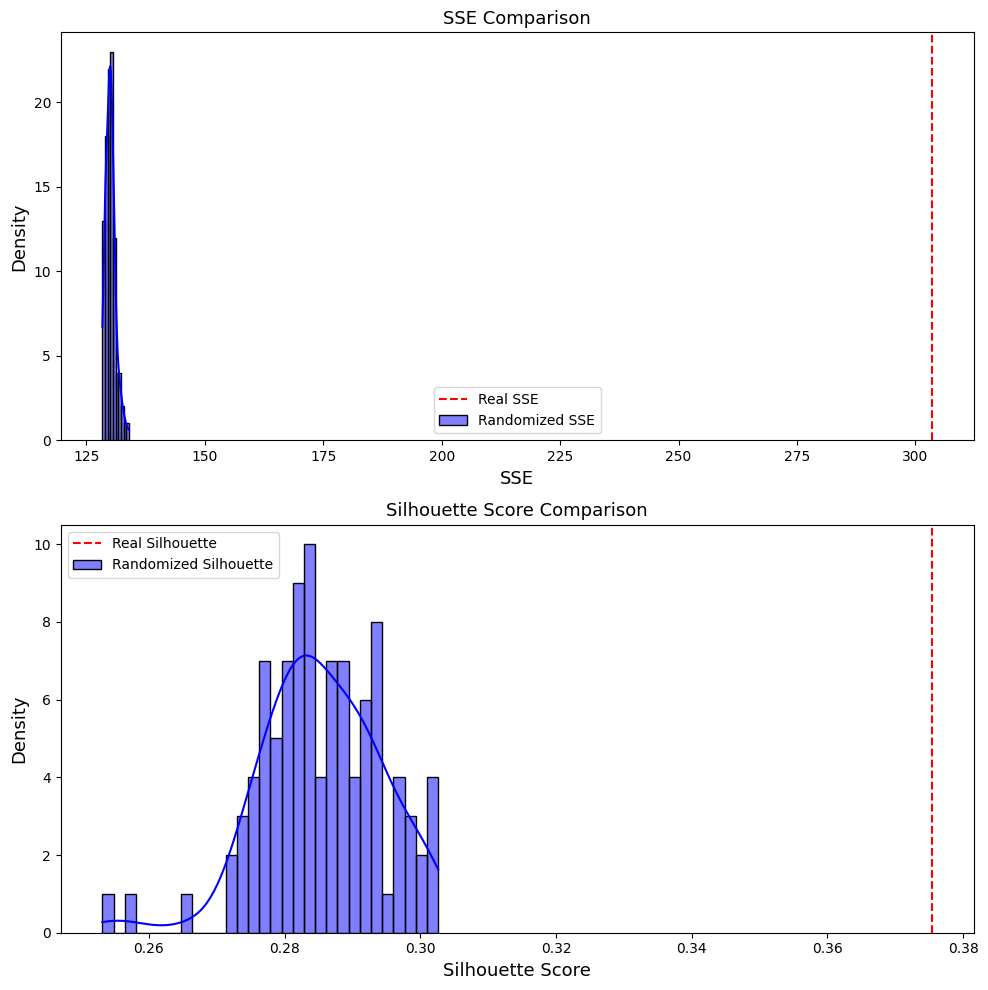

In [ ]:
sse_real = kmeans.inertia_
silhouette_real = silhouette_score(train_data, kmeans.labels_)
# Visualizza i risultati di SSE per i dati reali e randomizzati
plt.figure(figsize=(10, 10))

# Plotta gli histogrammi per SSE
plt.subplot(2, 1, 1)
sns.histplot(sse_random_results, kde=True, label='Randomized SSE', color='blue', bins=10)
plt.axvline(x=sse_real, color='red', linestyle='--', label='Real SSE')
plt.legend()
plt.xlabel('SSE',fontsize=13)
plt.ylabel('Density',fontsize=13)
plt.title('SSE Comparison',fontsize=13)

# Plotta gli histogrammi per Silhouette
plt.subplot(2, 1, 2)
sns.histplot(silhouette_random_results, kde=True, label='Randomized Silhouette', color='blue', bins=30)
plt.axvline(x=silhouette_real, color='red', linestyle='--', label='Real Silhouette')
plt.legend()
plt.xlabel('Silhouette Score',fontsize=13)
plt.ylabel('Density',fontsize=13)
plt.title('Silhouette Score Comparison',fontsize=13)

plt.tight_layout()
plt.show()

FILE TRAIN_CLEANED_V1
  
SCELTO K=5  
CORRELAZIONE -0.49  
SSE 460  
SILHOUETTE SCORE 0.3

-------------   
FILE TRAIN_CLEANED_V2  
  
K=7  
CORRELAIONE -0.39  
SSE 1588  
SILHOUETTE SCORE 0.16  

-------  

SELEZIONATE VARIABILI NUMVOTES, NUMREG TOTALIMAG E REVIEWSTOTAL  (da file v.2)  
k=5  
CORRELAZIONE -0.53  
sse 304  
silhouette 0.38  

# Bisecting K-Means

In [104]:
from sklearn.cluster import BisectingKMeans

In [105]:
bkmeans = BisectingKMeans(n_clusters=5)
bkmeans.fit(train_data)

BisectingKMeans(n_clusters=5)

In [106]:
sse = bkmeans.inertia_
print("SSE:", sse)
silhouette_avg = silhouette_score(train_data, bkmeans.labels_)
print("Silhouette coefficient:", silhouette_avg)

SSE: 330.23029791008037


Silhouette coefficient: 0.33553508438132823


In [107]:
import plotly.express as px

# Crea il grafico a dispersione interattivo
fig = px.scatter(
    df, 
    x="numRegions", 
    y="numVotes", 
    color=bkmeans.labels_.astype(str),  # Converti i label a stringa per usarli come categorie
    symbol=bkmeans.labels_.astype(str), # Usa simboli diversi per ogni cluster
    color_discrete_sequence=px.colors.qualitative.Bold,  # Palette colori "bright"
    title="Cluster Visualization with Plotly",
    labels={'startYear': 'startYear', 'popularityIndex': 'Popularity Index', 'color': 'Cluster'},
)

# Mostra il grafico
fig.show()


### Silhouette bisecting k-means


In [108]:
from yellowbrick.cluster import SilhouetteVisualizer

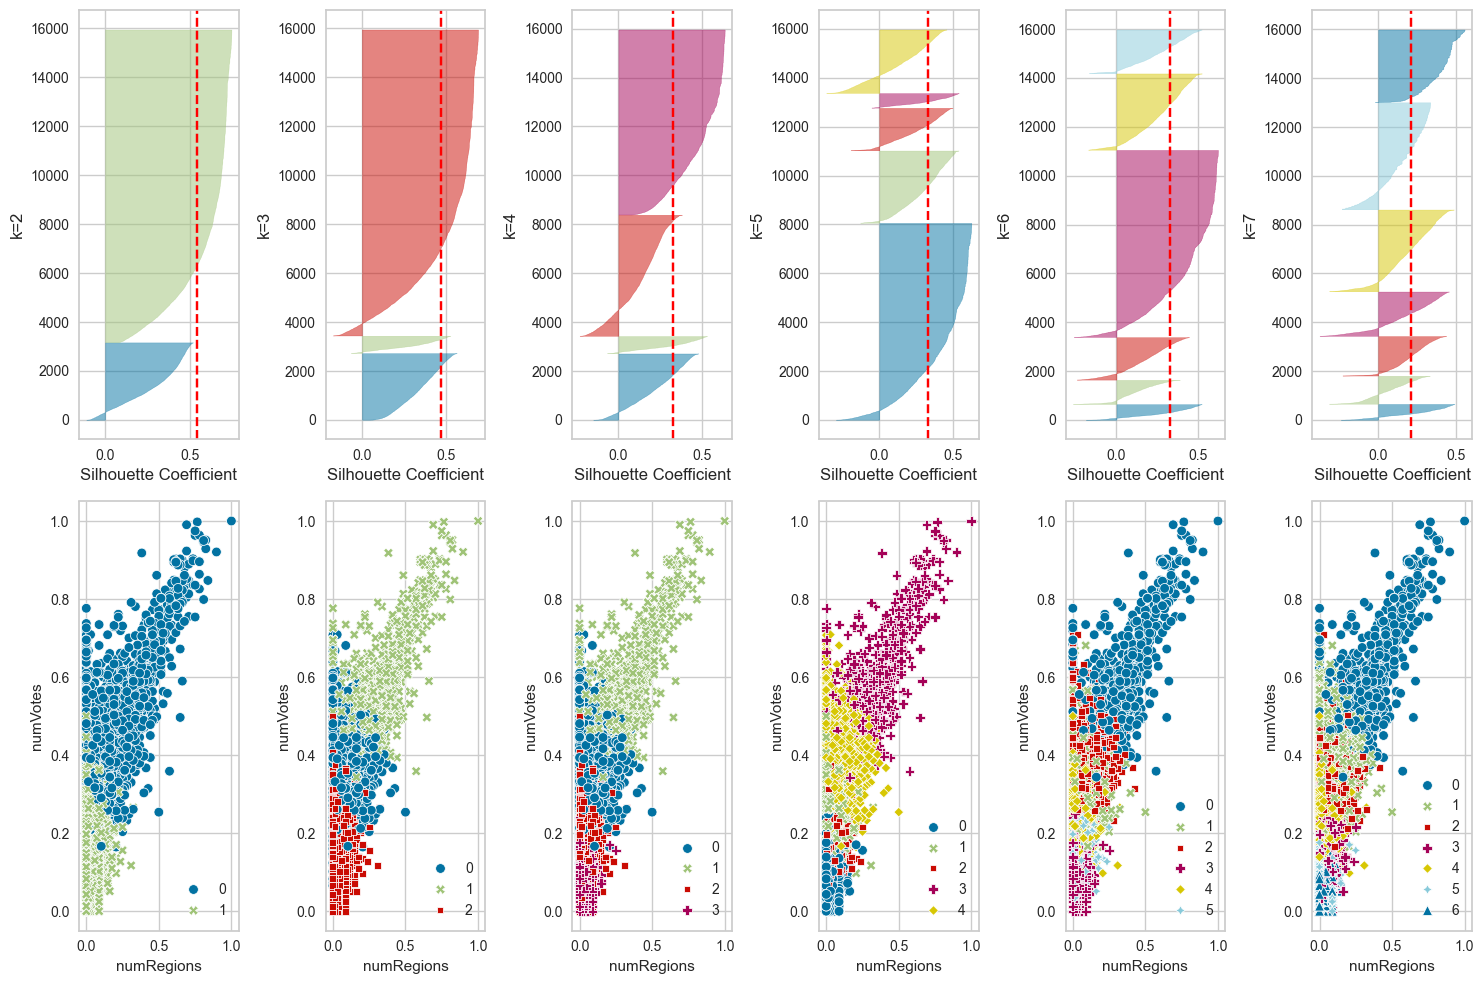

In [109]:

colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
n_clust = 8
fig, axs = plt.subplots(2,n_clust-2, figsize=(15,10))
for i in range(2, n_clust):
    bkmeans = BisectingKMeans(n_clusters=i)
    visualizer = SilhouetteVisualizer(bkmeans, colors=colors, ax=axs[0][i-2])
    axs[0][i-2].set_ylabel("k=" + str(i), fontsize=12)
    axs[0][i-2].set_xlabel("Silhouette Coefficient", fontsize=12)
    visualizer.fit(train_data)
    sns.scatterplot(data=df, x="numRegions", y="numVotes", hue=bkmeans.labels_, 
                    palette=sns.color_palette(colors[:i]), style=bkmeans.labels_, ax=axs[1][i-2])
plt.tight_layout()



In [110]:
silhouette_score(train_data, bkmeans.labels_)

np.float64(0.21022271529182726)

### Analysis by centroid-based methods

- K-Means (mandatory), Bisecting K-Means (optional), X-Means (optional);

- Choice the attributes, identify the best value of k, discuss the clusters.

### Analysis by density-based clustering

- DBSCAN (mandatory), OPTICS (optional);

- Choice the attributes, identify the best parameter configuration, discuss clusters.

### Analysis by hierarchical clustering

- Choice the attributes, the distance function, analyse several dendrograms.

### Final discussion

- Which is the best algorithm? Remember that best is studied w.r.t. several aggregate 
statistics, cluster distributions and w.r.t. the typology of algorithm used for that 
particular dataset;
